In [1]:
import DTAG_model_EF as dtagm
from importlib import reload
reload(dtagm)
import random
import pickle
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from matplotlib import cm


from IPython.display import clear_output

C:\Users\bjafino\anaconda3\envs\py36_dtag01\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\bjafino\anaconda3\envs\py36_dtag01\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
C:\Users\bjafino\anaconda3\envs\py36_dtag01\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  stacklevel=1)


In [2]:
import process_raster as pr
import pandas as pd
import seaborn as sns
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
plt.rc('font', family='serif')
import matplotlib.colors as colors
from matplotlib.cm import ScalarMappable
from PIL import Image
from scipy.stats import iqr
%matplotlib inline

## Inequality patterns - Data preparation

In [3]:
with open('results/results_NoPol.pkl', 'rb') as input:
    results_NoPol = pickle.load(input)
with open('results/results_HighDikes.pkl', 'rb') as input:
    results_HighDikes = pickle.load(input)
with open('results/results_LowDikes.pkl', 'rb') as input:
    results_LowDikes = pickle.load(input)
with open('results/results_Fertilizer.pkl', 'rb') as input:
    results_Fertilizer = pickle.load(input)
    
results_NoPol.keys()

dict_keys(['total_prod', 'temporal_prod', 'gini_coeffs', 'profit_district_avrg:', 'profit_district_avrg_not_normalized', 'profit_district_temporal'])

In [4]:
inequality_nopol = pd.DataFrame(results_NoPol['profit_district_avrg_not_normalized']).T
inequality_highdike = pd.DataFrame(results_HighDikes['profit_district_avrg_not_normalized']).T
inequality_lowdike = pd.DataFrame(results_LowDikes['profit_district_avrg_not_normalized']).T
inequality_fert = pd.DataFrame(results_Fertilizer['profit_district_avrg_not_normalized']).T

inequality_nopol['policy'] = 'Baseline'
inequality_highdike['policy'] = 'HighDikes'
inequality_lowdike['policy'] = 'LowDikes'
inequality_fert['policy'] = 'Fertilizer'

clim_dict = {'clim1': 'RCP4.5', 'clim2': 'RCP8.5'}
lud_dict = {'lud1': 'Expansion triple-rice', 'lud2': 'Back to double-rice'}
TE_dict = {'TE1': 'Small dam', 'TE3': 'Medium dam', 'TE5': 'Large dam'}

inequality_all = pd.DataFrame()
for inequality in [inequality_nopol, inequality_highdike, inequality_lowdike, inequality_fert]:
    inequality.reset_index(inplace=True)
    inequality['Climate'] = inequality['index'].apply(lambda x: clim_dict[x.rsplit('_', 3)[1]])
    inequality['LandUse'] = inequality['index'].apply(lambda x: lud_dict[x.rsplit('_', 3)[2]])
    inequality['UpstreamDam'] = inequality['index'].apply(lambda x: TE_dict[x.rsplit('_', 3)[3]])
    inequality_all = inequality_all.append(inequality)
    
inequality_all.reset_index(drop=True,inplace=True)

In [5]:
meanvals = inequality_all[inequality_all.columns[1:24]].mean(axis=1)

scaled = (inequality_all[inequality_all.columns[1:24]].T - meanvals) / meanvals

inequality_all[inequality_all.columns[1:24]] = scaled.T

inequality_all[inequality_all.columns[1:24]] *= 100

In [6]:
min_perc_change = np.min(np.min(inequality_all.iloc[:, 1:24]))
max_perc_change = np.max(np.max(inequality_all.iloc[:, 1:24]))

min_perc_change, max_perc_change

(-16.691801130919686, 21.354479553601475)

In [7]:
#overwrite
max_perc_change = 22
min_perc_change = -22

In [8]:
# inequality_all.to_csv('inequality_all_earth_future_new.csv', index=False)

In [9]:
policies = ['Baseline', 'HighDikes', 'LowDikes', 'Fertilizer']
dam_scenarios = ['Small dam', 'Medium dam', 'Large dam']

## Inequality patterns - Code

In [10]:
scales = np.linspace(0, 1, 7)
scales = np.linspace(min_perc_change,max_perc_change,7)
cmap = plt.get_cmap("RdYlGn")
norm = plt.Normalize(scales.min(), scales.max())

In [11]:
def plot_district_profit_loop(output_var, ax, vmin=0, vmax=0, title=None, legend=False):
    
    dtag_gdf = gpd.read_file('DTAG_districts.shp')
    dtag_gdf = dtag_gdf.loc[dtag_gdf['DN']>0]
    dtag_gdf.reset_index(inplace=True)

    dtag_gdf['profit'] = dtag_gdf['DN'].map(output_var)
    
    if vmax==0:
        vmin = dtag_gdf['profit'].min()
        vmax = dtag_gdf['profit'].max()
    
    dtag_gdf.plot(column='profit', legend=legend, ax=ax, cmap=cmap, linewidth=0.3, edgecolor='black',
                  vmin=vmin, vmax=vmax)

    for r in ['right', 'top', 'left', 'bottom']:
        ax.spines[r].set_visible(False)

    ax.set_xticks([])
    ax.set_yticks([])
    
    if title:
        ax.set_title(title)
    else:
        plt.title('Average annual profit of farmers at district level (VND)')

def plot_inequality_pattern(climate,landuse, vmin=None, vmax=None):
    inequality_ = inequality_all.loc[(inequality_all['Climate']==climate) & (inequality_all['LandUse']==landuse)]
    inequality_.reset_index(drop=True,inplace=True)
    
    if vmin:
        pass
    else:
        vmin = np.min(np.min(inequality_[inequality_.columns[1:24]]))
        vmax = np.max(np.max(inequality_[inequality_.columns[1:24]]))

    fig, axes = plt.subplots(3, 5, figsize=(20,10))
    i,j = 0,0

    ###looping each figure
    for dam in dam_scenarios:
        for pol in policies:
            inequality_one_scenario = inequality_.loc[(inequality_['policy']==pol)&(inequality_['UpstreamDam']==dam)]
            inequality_one_scenario = inequality_one_scenario[inequality_one_scenario.columns[1:24]].iloc[0]
            minval = np.min(inequality_one_scenario.values)
            maxval = np.max(inequality_one_scenario.values)
            inequality_one_scenario = dict(zip(inequality_one_scenario.index,inequality_one_scenario.values))

            legend=False
            
            plot_district_profit_loop(inequality_one_scenario, title=' ', ax=axes[i,j], legend=legend, vmin=vmin, vmax=vmax)

            if j < 3:
                j += 1
            else:
                j = 0
                i += 1

    ###colorbar legend
    sm =  ScalarMappable(norm=norm, cmap=cmap)
    sm.set_array([])
    cbaxes = fig.add_axes([0.76, 0.48, 0.015, 0.4])
    cbar = fig.colorbar(sm, ax=axes[0,-1], cax=cbaxes)
    for i in [0,1,2]:
        axes[i, -1].axis('off')
    cbar.ax.set_title("Profitability\ndeviation\nfrom\naverage (%)", fontsize=14)

    ###column and row labels
    axes[0,0].text(0.4,1.1,'Baseline', verticalalignment='center', transform=axes[0,0].transAxes, fontsize=16)
    axes[0,1].text(0.4,1.1,'High dikes', verticalalignment='center', transform=axes[0,1].transAxes, fontsize=16)
    axes[0,2].text(0.4,1.1,'Low dikes', verticalalignment='center', transform=axes[0,2].transAxes, fontsize=16)
    axes[0,3].text(0.4,1.1,'Fertilizer', verticalalignment='center', transform=axes[0,3].transAxes, fontsize=16)
    axes[0,0].text(-0.07,0.55,'Small dam\ndevelopment', horizontalalignment='center', transform=axes[0,0].transAxes, 
                   fontsize=16, rotation='vertical')
    axes[1,0].text(-0.07,0.55,'Medium dam\ndevelopment', horizontalalignment='center', transform=axes[1,0].transAxes, 
                   fontsize=16, rotation='vertical')
    axes[2,0].text(-0.07,0.55,'Large dam\ndevelopment', horizontalalignment='center', transform=axes[2,0].transAxes, 
                   fontsize=16, rotation='vertical')

## Inequality patterns - Plot

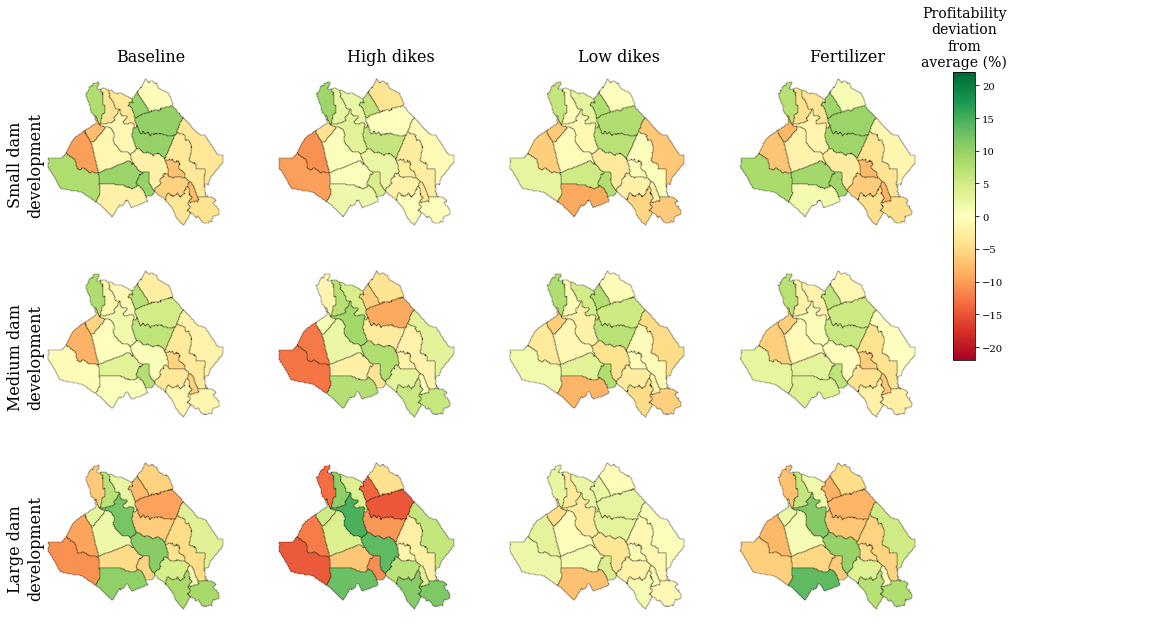

In [12]:
#####################
#RCP4.5 expansion triple rice
plot_inequality_pattern('RCP4.5', 'Expansion triple-rice', vmin=min_perc_change, vmax=max_perc_change)
plt.savefig('figs_paper/res_pattern_rcp45_3rice_v04_2.png', dpi=300, bbox_inches='tight', transparent=True)

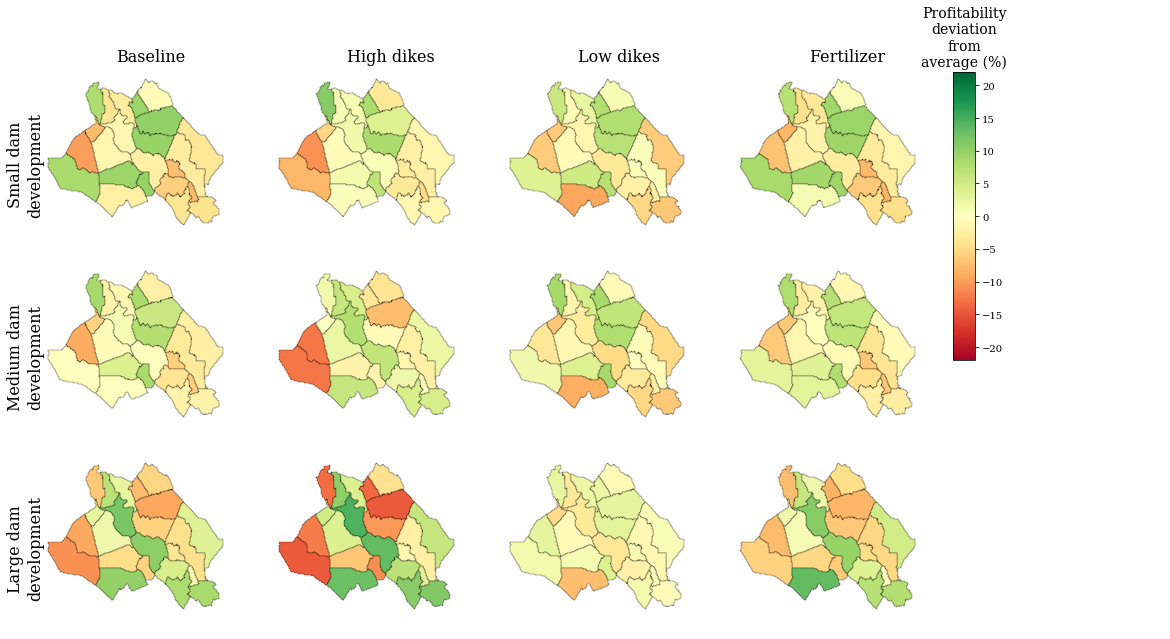

In [13]:
#####################
#RCP8.5 expansion triple rice
plot_inequality_pattern('RCP8.5', 'Expansion triple-rice', vmin=min_perc_change, vmax=max_perc_change)
plt.savefig('figs_paper/res_pattern_rcp85_3rice_v04_2.png', dpi=300, bbox_inches='tight', transparent=True)

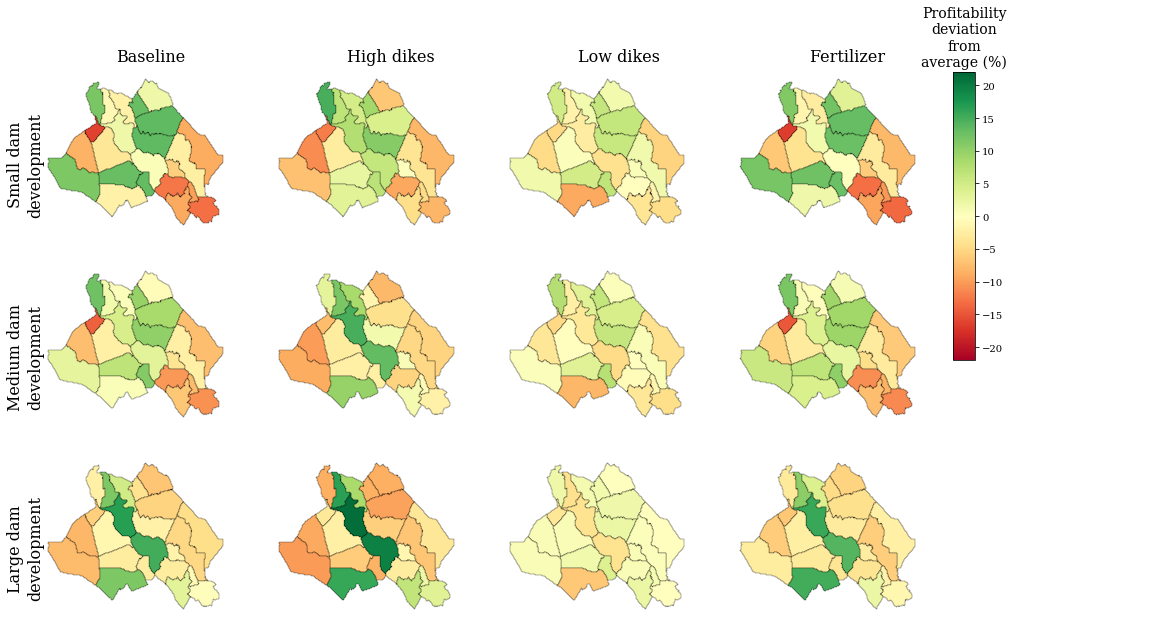

In [14]:
#####################
#RCP4.5 shift to double rice
plot_inequality_pattern('RCP4.5', 'Back to double-rice', vmin=min_perc_change, vmax=max_perc_change)
plt.savefig('figs_paper/res_pattern_rcp45_2rice_v04_2.png', dpi=300, bbox_inches='tight', transparent=True)

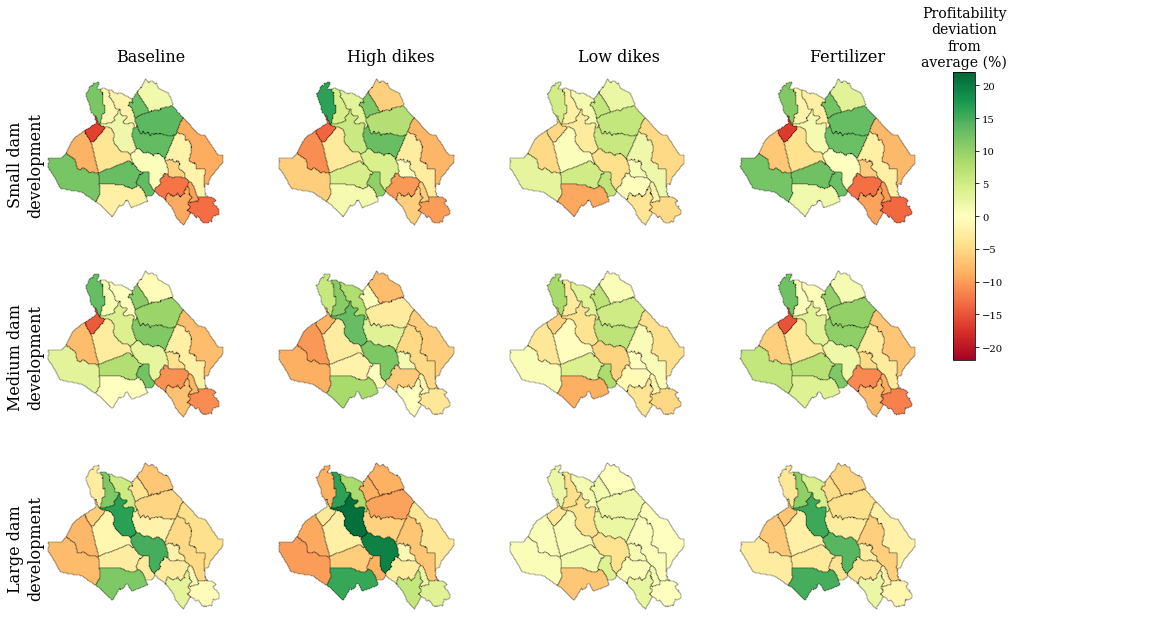

In [15]:
#####################
#RCP8.5 shift to double rice
plot_inequality_pattern('RCP8.5', 'Back to double-rice', vmin=min_perc_change, vmax=max_perc_change)
plt.savefig('figs_paper/res_pattern_rcp85_2rice_v04_2.png', dpi=300, bbox_inches='tight', transparent=True)

In [16]:
dtag_gdf = gpd.read_file('DTAG_districts.shp')
dtag_gdf = dtag_gdf.loc[dtag_gdf['DN']>0]
dtag_gdf.reset_index(inplace=True)

cats_ = {'Cluster 1': [13, 14, 16],
         'Cluster 2': [9, 10, 11, 12],
         'Cluster 3': [18, 20, 21],
         'Cluster 4': [2, 6, 7]}

cats = {}
for k, v in cats_.items():
    for _ in v:
        cats[_] = k
for dn in dtag_gdf['DN']:
    if dn not in cats.keys():
        cats[dn] = 'Others'
        
dtag_gdf['cluster'] = dtag_gdf['DN'].map(cats)

In [17]:
inequality_all['cluster_1'] = inequality_all[cats_['Cluster 1']].mean(axis=1)
inequality_all['cluster_2'] = inequality_all[cats_['Cluster 2']].mean(axis=1)
inequality_all['cluster_3'] = inequality_all[cats_['Cluster 3']].mean(axis=1)
inequality_all['cluster_4'] = inequality_all[cats_['Cluster 4']].mean(axis=1)

In [18]:
inequality_all_ = pd.melt(inequality_all, id_vars=['UpstreamDam', 'policy'], value_vars=['cluster_1', 'cluster_2', 'cluster_3', 'cluster_4'])

In [19]:
newcolors = sns.color_palette("Set2")
newcolors = newcolors[:5]
grey = (232/256, 232/256, 232/256, 1)
newcolors[4] = grey
newcmp = ListedColormap(newcolors)

C:\Users\bjafino\anaconda3\envs\py36_dtag01\lib\site-packages\matplotlib\colors.py:214: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  c = np.array(c)


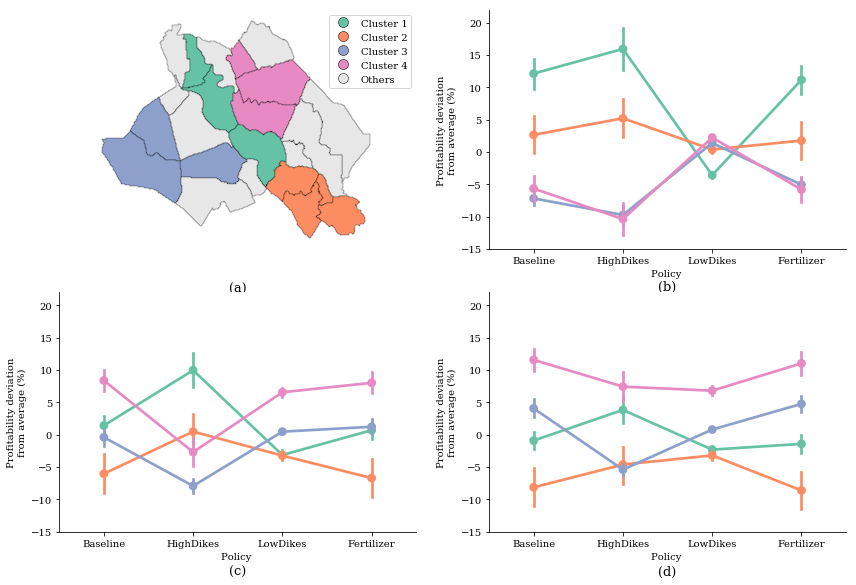

In [21]:
fig, axes = plt.subplots(2,2, figsize=(12,8))

counter = 0
for i in range(2):
    for j in range(2):
        counter += 1
        if counter > 1:
            
            dam = list(np.unique(inequality_all_['UpstreamDam']))[counter-2]
            
            _ = inequality_all_.loc[inequality_all_['UpstreamDam']==dam]
                        
            sns.pointplot(data=_, x='policy', y='value', hue='variable', ax=axes[i,j], palette='Set2')
            axes[i,j].set_ylim(-15,22)
            axes[i,j].get_legend().remove()
            axes[i,j].set_ylabel('Profitability deviation\nfrom average (%)')
            axes[i,j].set_xlabel('Policy ')
            
        else:
            dtag_gdf.plot(column='cluster', cmap=newcmp, linewidth=0.3, edgecolor='black', legend=True, ax=axes[i,j])
            axes[i,j].set_xlim(455000, 625000)
            axes[i,j].axis('off')
            
            for legend_handle in axes[i,j].get_legend().legendHandles:  
                legend_handle._legmarker.set_markeredgewidth(0.5)
                legend_handle._legmarker.set_markeredgecolor('black')

axes[0,0].text(0.5,-0.18, "(a)", size=13, ha="center", transform=axes[0,0].transAxes)
axes[0,1].text(0.5,-0.17, "(b)", size=13, ha="center", transform=axes[0,1].transAxes)
axes[1,0].text(0.5,-0.18, "(c)", size=13, ha="center", transform=axes[1,0].transAxes)
axes[1,1].text(0.5,-0.18, "(d)", size=13, ha="center", transform=axes[1,1].transAxes)
sns.despine()
plt.tight_layout()
plt.savefig('figs_paper/inequality_clusters.png', dpi=500, bbox_inches='tight', transparent=True)

## Efficiency vs equity - Code

In [22]:
def gini(array):
    """Calculate the Gini coefficient of a numpy array."""
    #https://github.com/oliviaguest/gini/blob/master/gini.py
    # based on bottom eq:
    # http://www.statsdirect.com/help/generatedimages/equations/equation154.svg
    # from:
    # http://www.statsdirect.com/help/default.htm#nonparametric_methods/gini.htm
    # All values are treated equally, arrays must be 1d:
    array = array.flatten()
    if np.amin(array) < 0:
        # Values cannot be negative:
        array -= np.amin(array)
    # Values cannot be 0:
    array += 0.0000001
    # Values must be sorted:
    array = np.sort(array)
    # Index per array element:
    index = np.arange(1,array.shape[0]+1)
    # Number of array elements:
    n = array.shape[0]
    # Gini coefficient:
    return ((np.sum((2 * index - n  - 1) * array)) / (n * np.sum(array)))

In [23]:
def plot_gini_prod(data, x, y, hue=None, style=None):
    fg = plt.figure(figsize=(5,5))
#     fg.clf()
    ax = fg.add_subplot(111)
    
    ##arrow
    ax.annotate('', xy=(0, 1.05), xycoords='axes fraction', xytext=(0, 0.95), 
                arrowprops=dict(arrowstyle="-|>, head_width=0.5, head_length=2", color='black'))
    ax.annotate('', xy=(1.05, 0), xycoords='axes fraction', xytext=(0.95, 0), 
                arrowprops=dict(arrowstyle="-|>, head_width=0.5, head_length=2", color='black'))
    
    #artificial axes
    ax.annotate('', xy=(0, -0.007), xycoords='axes fraction', xytext=(0, 1), 
                arrowprops=dict(arrowstyle="-", color='black'))
    ax.annotate('', xy=(-0.007, 0), xycoords='axes fraction', xytext=(1, 0), 
                arrowprops=dict(arrowstyle="-", color='black'))
    
    
    sns.scatterplot(data=gini_prod_df, x='total_prod', y='gini_mean', hue=hue, style=style, s=180, ax=ax)
    
    ax.set_xlabel('Total rice production (mil ton)', size=12)
    ax.set_ylabel('Average gini coefficient', size=12)
    for loc in ['right', 'left', 'top', 'bottom']:
        ax.spines[loc].set_visible(False)
        
    plt.gca().invert_yaxis()
    
    if hue or style:
        plt.legend(bbox_to_anchor=(1, 1), loc='upper left', ncol=1)

## Efficiency vs equity - Data prep

In [24]:
with open('results/results_NoPol.pkl', 'rb') as input:
    results_NoPol = pickle.load(input)
with open('results/results_HighDikes.pkl', 'rb') as input:
    results_HighDikes = pickle.load(input)
with open('results/results_LowDikes.pkl', 'rb') as input:
    results_LowDikes = pickle.load(input)
with open('results/results_Fertilizer.pkl', 'rb') as input:
    results_Fertilizer = pickle.load(input)
    
results_NoPol.keys()

dict_keys(['total_prod', 'temporal_prod', 'gini_coeffs', 'profit_district_avrg:', 'profit_district_avrg_not_normalized', 'profit_district_temporal'])

In [25]:
inequality_nopol = pd.DataFrame(results_NoPol['profit_district_avrg_not_normalized']).T
inequality_highdike = pd.DataFrame(results_HighDikes['profit_district_avrg_not_normalized']).T
inequality_lowdike = pd.DataFrame(results_LowDikes['profit_district_avrg_not_normalized']).T
inequality_fert = pd.DataFrame(results_Fertilizer['profit_district_avrg_not_normalized']).T

inequality_nopol['policy'] = 'Baseline'
inequality_highdike['policy'] = 'HighDikes'
inequality_lowdike['policy'] = 'LowDikes'
inequality_fert['policy'] = 'Fertilizer'

clim_dict = {'clim1': 'RCP4.5', 'clim2': 'RCP8.5'}
lud_dict = {'lud1': 'Expansion triple-rice', 'lud2': 'Back to double-rice'}
TE_dict = {'TE1': 'Small dam', 'TE3': 'Medium dam', 'TE5': 'Large dam'}

inequality_all = pd.DataFrame()
for inequality in [inequality_nopol, inequality_highdike, inequality_lowdike, inequality_fert]:
    inequality.reset_index(inplace=True)
    inequality['Climate'] = inequality['index'].apply(lambda x: clim_dict[x.rsplit('_', 3)[1]])
    inequality['LandUse'] = inequality['index'].apply(lambda x: lud_dict[x.rsplit('_', 3)[2]])
    inequality['UpstreamDam'] = inequality['index'].apply(lambda x: TE_dict[x.rsplit('_', 3)[3]])
    inequality_all = inequality_all.append(inequality)
    
inequality_all.reset_index(drop=True,inplace=True)

In [27]:
#new: calculate gini from the maps above

inequality_all['gini'] = inequality_all.apply(lambda x: gini(np.array(x[1:24])), axis=1)

gini_prod_df = pd.DataFrame()
policies = ['Baseline', 'HighDikes', 'LowDikes', 'Fertilizer']

for i, result in enumerate([results_NoPol, results_HighDikes, results_LowDikes, results_Fertilizer]):
    result_df = pd.DataFrame()
    result_df['scenario'] = result['total_prod'].keys()
    result_df['total_prod'] = result['total_prod'].values()
    result_df['Policy'] = policies[i]
    
    gini_prod_df = gini_prod_df.append(result_df)
    
gini_prod_df['TE'] = gini_prod_df['scenario'].apply(lambda x: x[-3:])
TE_dict = {'TE1': 'Small dam', 'TE3': 'Medium dam', 'TE5': 'Large dam'}
gini_prod_df['TE'] = gini_prod_df['TE'].apply(lambda x: TE_dict[x])

gini_prod_df['clim'] = gini_prod_df['scenario'].apply(lambda x: x[4:9])
clim_dict = {'clim1': 'RCP4.5', 'clim2': 'RCP8.5'}
gini_prod_df['clim'] = gini_prod_df['clim'].apply(lambda x: clim_dict[x])

gini_prod_df['lud'] = gini_prod_df['scenario'].apply(lambda x: x[10:14])
lud_dict = {'lud1': 'Expansion triple-rice', 'lud2': 'Back to double-rice'}
gini_prod_df['lud'] = gini_prod_df['lud'].apply(lambda x: lud_dict[x])

gini_prod_df['total_prod'] /=1000 * 1e6

gini_prod_df['key'] = gini_prod_df['Policy'] + '_' + gini_prod_df['scenario']
inequality_all['key'] = inequality_all['policy'] + '_' + inequality_all['index']
gini_dict = dict(zip(inequality_all['key'], inequality_all['gini']))

gini_prod_df['gini_mean'] = gini_prod_df['key'].apply(lambda x: gini_dict[x])

In [31]:
# gini_prod_df.to_csv('gini_efficiency_earth_future_new.csv', index=False)

## Efficiency vs equity - Plot

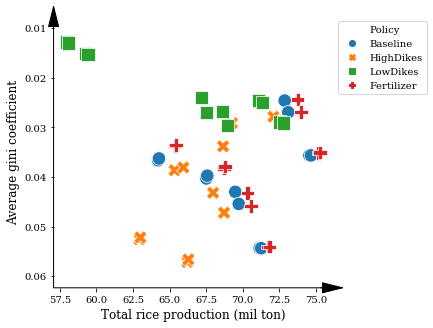

In [29]:
plot_gini_prod(data=gini_prod_df, x='total_prod', y='gini_mean', hue='Policy', style='Policy')
plt.savefig('figs_paper/res_equity_v_efficiency_policy_v03.png', dpi=300, bbox_inches='tight', transparent=True)

In [30]:
# gini_prod_df.to_excel('results/efficiency_equity_v02_2.xlsx')